In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import json
import cv2
plt.style.use('bmh')

In [2]:
train_df = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')

In [3]:
train_df.head()

image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

## Dataset Stats

In [4]:
print("Total number of training images: ", len(train_df))

Total number of training images:  21397


In [5]:
with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    data = json.load(f)
print('Classes')
for i in range(len(data)):
    print(i,": ", data[str(i)])

Classes
0 :  Cassava Bacterial Blight (CBB)
1 :  Cassava Brown Streak Disease (CBSD)
2 :  Cassava Green Mottle (CGM)
3 :  Cassava Mosaic Disease (CMD)
4 :  Healthy


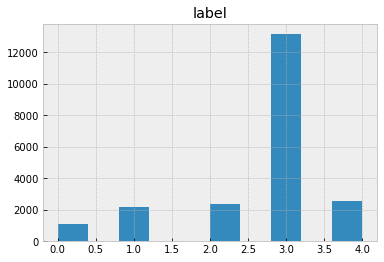

In [6]:
train_df.hist();

In [7]:
train_df['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

Here we can clearly see that there is a large class imbalance in this dataset. Class 3 has more samples than the remaining classes combined.

## Image Dimensions

In [8]:
train_dir = "../input/cassava-leaf-disease-classification/train_images"

In [9]:
image_sizes = []
for f in os.listdir(train_dir):
    image = cv2.imread(os.path.join(train_dir, f))
    image_sizes.append(image.shape)
    
image_sizes = set(image_sizes)
image_sizes

{(600, 800, 3)}

All of the images are of size 600x800 which is quite large so the images will have to be downsampled during training.

In [10]:
# n must be even
def plot_examples(ids, n):
    np.random.seed(0)
    rand_ids = np.random.choice(ids, size=n)

    fig = plt.figure(figsize=(15, 10))
    for i in range(n):
        I = cv2.imread(os.path.join(train_dir, rand_ids[i]))
        fig.add_subplot(int(n/2),2,i+1)
        plt.imshow(I[:,:,::-1])
        plt.grid(None)
        plt.xlabel(rand_ids[i])

## Class 0 (Cassava Bacterial Blight)

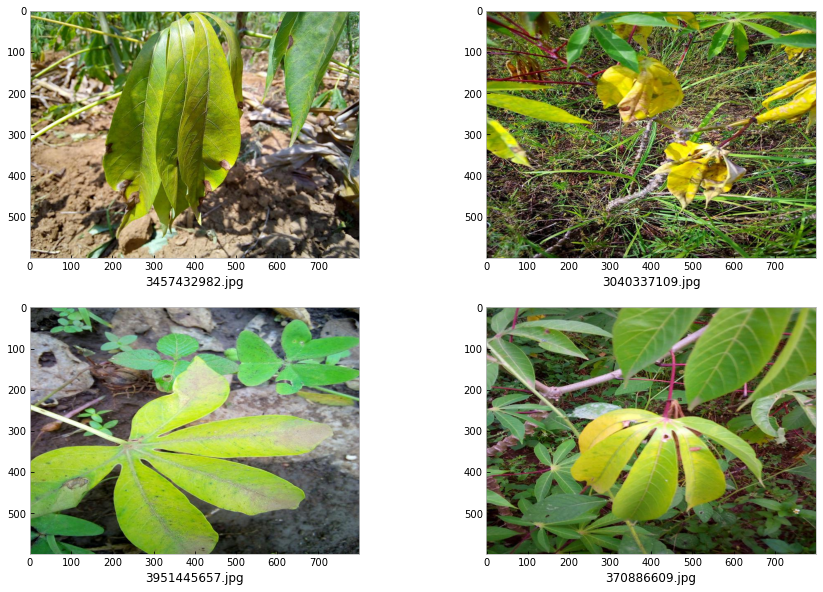

In [11]:
class_0 = train_df.loc[train_df['label'] == 0, ['image_id']].values.flatten()
plot_examples(class_0, 4)  

## Class 1 (Cassava Brown Streak Disease)

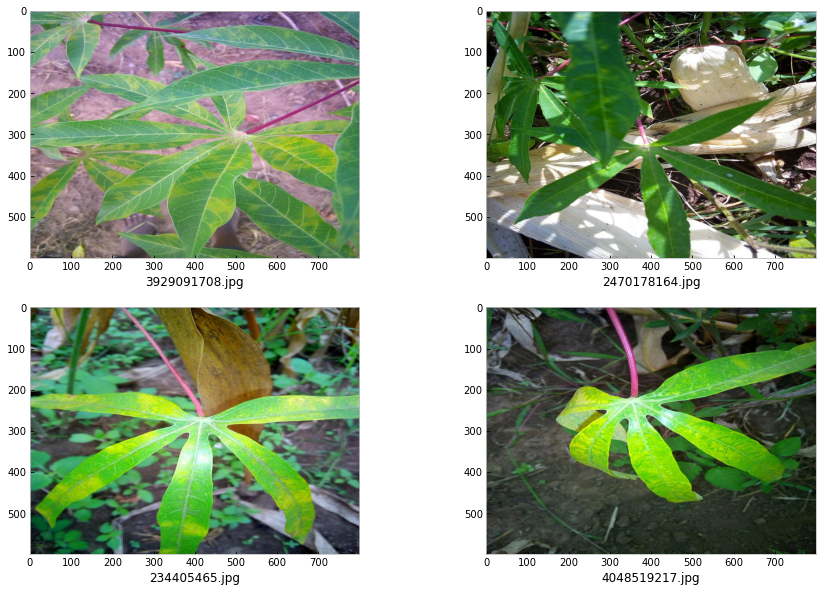

In [12]:
class_1 = train_df.loc[train_df['label'] == 1, ['image_id']].values.flatten()
plot_examples(class_1, 4)  

## Class 2 (Cassava Green Mottle)

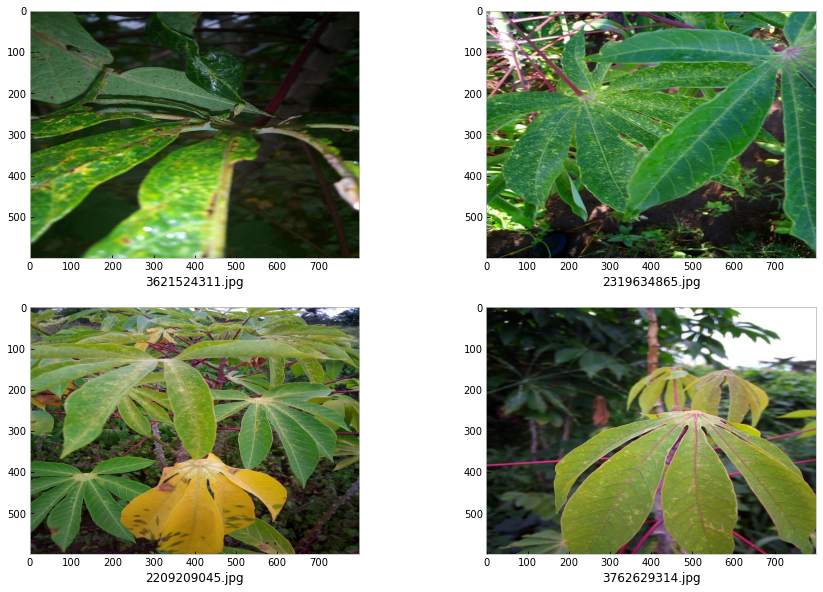

In [13]:
class_2 = train_df.loc[train_df['label'] == 2, ['image_id']].values.flatten()
plot_examples(class_2, 4)  

## Class 3 (Cassava Mosaic Disease)

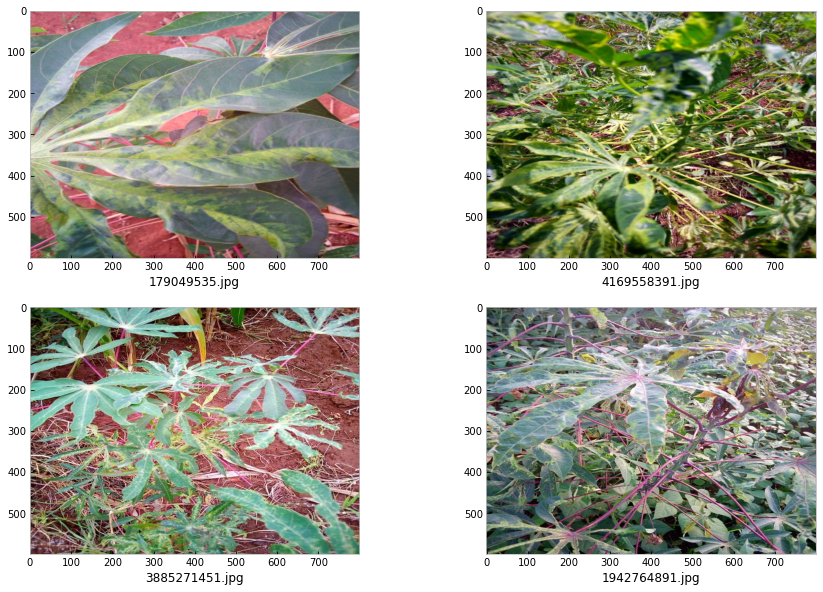

In [14]:
class_3 = train_df.loc[train_df['label'] == 3, ['image_id']].values.flatten()
plot_examples(class_3, 4)  

## Class 4 (Healthy)

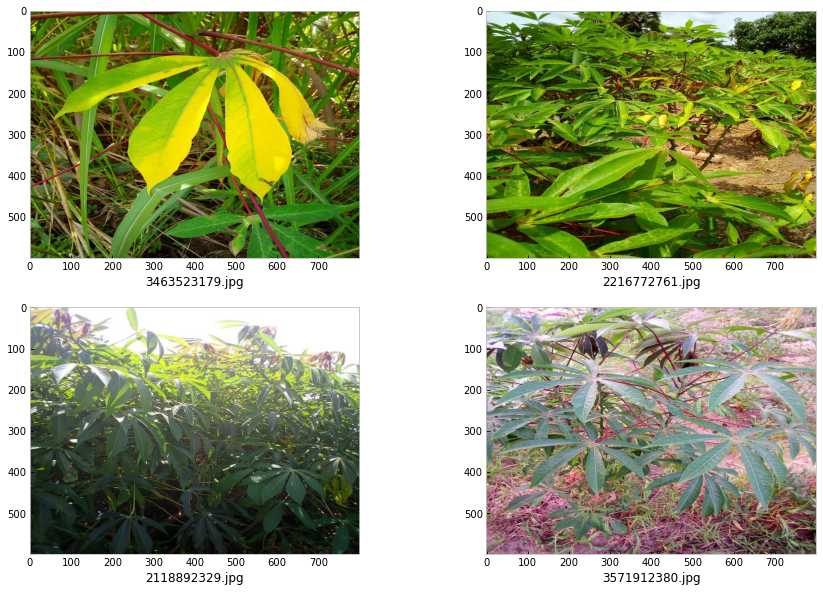

In [15]:
class_4 = train_df.loc[train_df['label'] == 4, ['image_id']].values.flatten()
plot_examples(class_4, 4)  

Given that this is a real world dataset, the images have been taken using different cameras and under different conditions. The images vary greatly in quality, background/environment, light exposure, perspective, zoom, etc.

## Image Augmentations

In [16]:
import albumentations as A

In [17]:
transform = A.Compose([
    A.RandomResizedCrop(256,256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.25),
    A.Transpose(p=0.25),
    A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5)
#     A.Normalize(
#                 mean=[0.485, 0.456, 0.406], 
#                 std=[0.229, 0.224, 0.225], 
#                 max_pixel_value=255.0, 
#                 p=1.0)
])

In [18]:
def plot_augmentations(ids, n, transform):
#     np.random.seed(0)
    rand_ids = np.random.choice(ids, size=n)
    
    fig = plt.figure(figsize=(15, 25))
    fig.suptitle('Original Image vs Transformed Image')
    for i in range(0, 2*n, 2):
        image = cv2.imread(os.path.join(train_dir, rand_ids[int(i/2)]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fig.add_subplot(n, 2, i+1)
        plt.imshow(image)
        plt.grid(None)
        
        transformed = transform(image=image)
        transformed_image = transformed['image']
        fig.add_subplot(n, 2, i+2)
        plt.imshow(transformed_image)
        plt.grid(None)

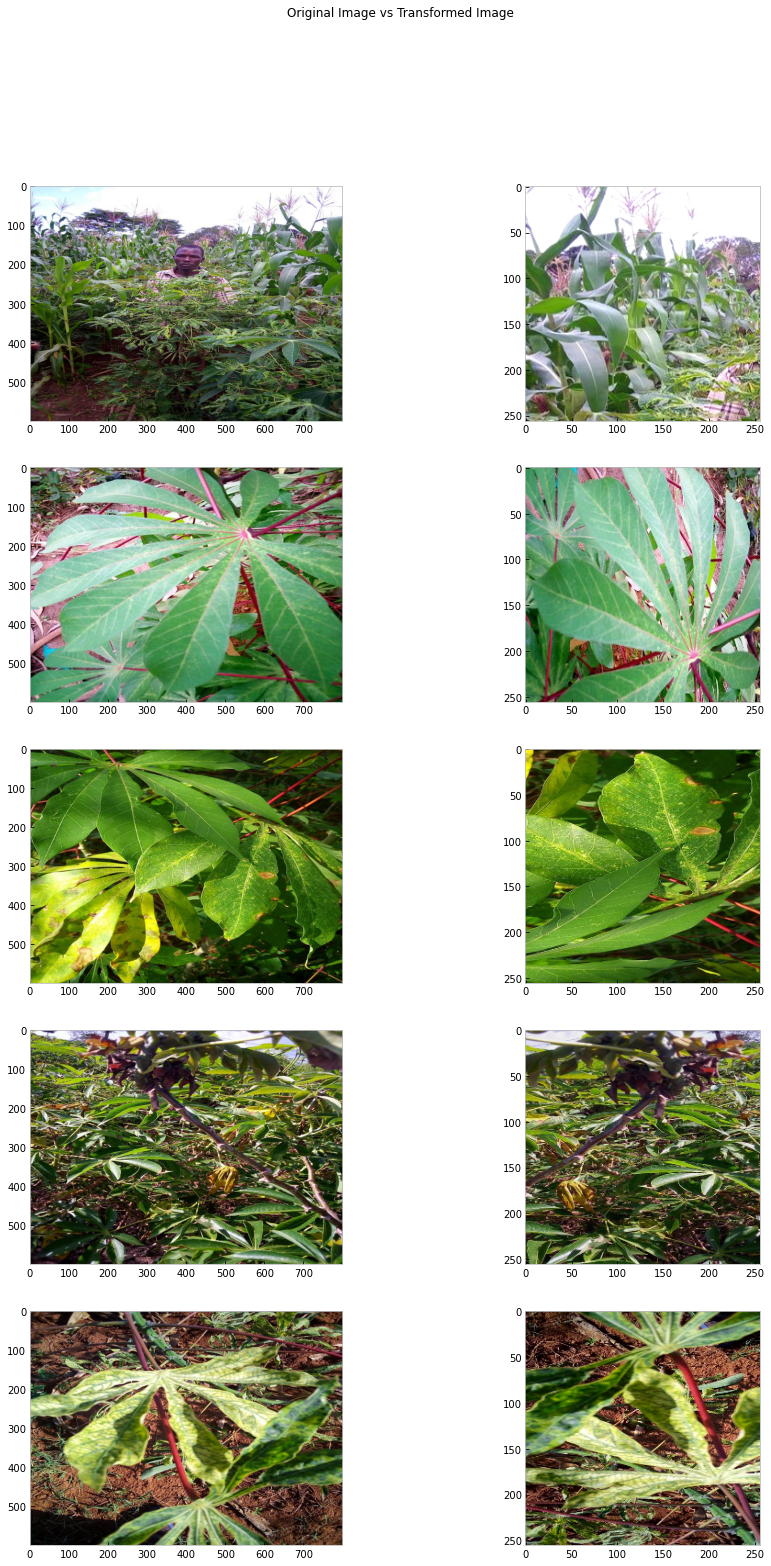

In [19]:
ids = train_df['image_id'].values
plot_augmentations(ids, 5, transform)

In [20]:
test_df = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
test_df

image_id  label
0  2216849948.jpg      4